In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_HSDM_2D(threshold, mu, ndt, sigma=1, dt=0.001):
    x = np.zeros(mu.shape)
    
    rt = 0
    
    while np.linalg.norm(x, 2) < threshold:
        x += mu*dt + sigma*np.sqrt(dt)*np.random.normal(0, 1, mu.shape)
        rt += dt
    
    theta = np.arctan2(x[1], x[0])   
    
    return ndt+rt, theta

In [3]:
data = pd.read_csv('_data/Kvam_2019_orientation_judgments_data.csv')
data = data[data['isCued'] == 0].reset_index(drop=True)
data['absoluteDeviation'] = data['absoluteDeviation']/np.pi * 180

best_fitting = pd.read_csv('Kvam_2019_best_estimation.csv', index_col=0)
best_fitting['drift magnitude'] = np.sqrt(best_fitting['mux']**2 + best_fitting['muy']**2)
best_fitting['drift direction'] = np.arctan2(best_fitting['muy'], best_fitting['mux'])
best_fitting['drift direction'] = np.abs(best_fitting['drift direction']/np.pi * 180)

In [4]:
best_fitting.describe()

,sbj,isSpeed,jitter,threshold,mux,muy,ndt,G2,drift magnitude,drift direction
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,150.083333,0.500000,30.000000,1.980626,4.399155,-0.034850,0.250225,-315.543209,4.405458,2.634681
std,37.792148,0.503509,12.333397,0.981710,1.848454,0.224724,0.100691,131.533544,1.847226,2.161021
min,100.000000,0.000000,15.000000,0.827698,1.607215,-0.604798,0.100000,-598.742881,1.610087,0.085067
25%,117.500000,0.000000,15.000000,1.244444,2.920339,-0.191000,0.163096,-401.339075,2.922748,0.955787
50%,145.000000,0.500000,30.000000,1.640967,3.946300,-0.009989,0.258058,-308.652027,3.949961,2.125635
75%,182.500000,1.000000,45.000000,2.561924,5.782120,0.106548,0.323155,-222.780806,5.789761,3.917263
max,210.000000,1.000000,45.000000,4.983516,7.500000,0.495034,0.458960,-51.433746,7.510286,10.704074


In [5]:
best_fitting.groupby(by='isSpeed')['threshold'].mean()

isSpeed
0    2.321938
1    1.639313
Name: threshold, dtype: float64

In [6]:
best_fitting.groupby(by='jitter')['drift magnitude'].mean()

jitter
15    6.428579
30    4.092603
45    2.695191
Name: drift magnitude, dtype: float64

In [7]:
best_fitting.groupby(by='jitter')['drift direction'].mean()

jitter
15    1.737368
30    2.543762
45    3.622912
Name: drift direction, dtype: float64

In [8]:
prediction = {'sbj': [],
              'isSpeed': [],
              'jitter':[],
              'Theta':[],
              'RT':[]}

for sbj in data['Participant'].unique():
    prms_sbj = best_fitting[best_fitting['sbj']==sbj]
    for sp in range(2):
        for jit in [15, 30, 45]:
            prms_cond = prms_sbj[(prms_sbj['isSpeed']==sp) & (prms_sbj['jitter']==jit)]
            threshold = prms_cond['threshold'].values[0]
            ndt = prms_cond['ndt'].values[0]
            mu = np.array([prms_cond['mux'].values[0], 
                           prms_cond['muy'].values[0]])
            

            for n in range(300):
                rt, theta = simulate_HSDM_2D(threshold, mu, ndt)
                prediction['sbj'].append(sbj)
                prediction['isSpeed'].append(sp)
                prediction['jitter'].append(jit)
                prediction['Theta'].append(np.abs(theta)/np.pi * 180)
                prediction['RT'].append(rt)
            

In [9]:
prediction_df = pd.DataFrame(prediction)
prediction_df

,sbj,isSpeed,jitter,Theta,RT
0,100,0,15,28.474580,1.018000
1,100,0,15,8.673142,1.269000
2,100,0,15,0.954185,1.049000
3,100,0,15,14.527451,0.930000
4,100,0,15,10.157343,0.758000
...,...,...,...,...,...
21595,210,1,45,0.663126,0.662418
21596,210,1,45,62.687206,0.666418
21597,210,1,45,55.106509,0.613418
21598,210,1,45,11.866841,1.207418


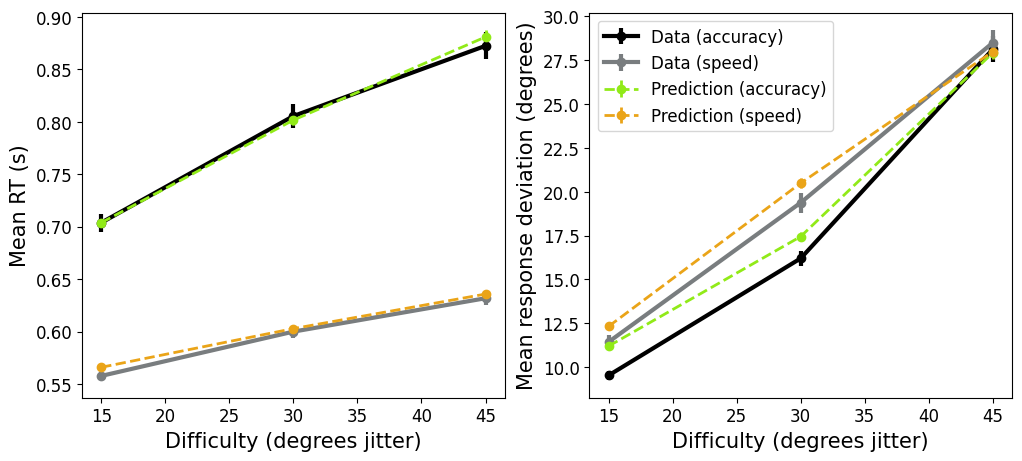

In [10]:
plt.figure(figsize=(12, 5))

plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

plt.subplot(121)
GRT = data.groupby(by=['jitter', 'isSpeed'])['RT'].mean()
GRT_err = data.groupby(by=['jitter', 'isSpeed'])['RT'].sem()
plt.errorbar(x=[15, 30, 45],
             y=GRT.iloc[0::2],
             yerr=GRT_err.iloc[0::2], fmt='-o', linewidth=3, c='black', label='Data (accuracy)')
plt.errorbar(x=[15, 30, 45],
             y=GRT.iloc[1::2],
             yerr=GRT_err.iloc[1::2], fmt='-o', linewidth=3, c='#797d7f', label='Data (speed)')

GRT = prediction_df.groupby(by=['jitter', 'isSpeed'])['RT'].mean()
GRT_err = prediction_df.groupby(by=['jitter', 'isSpeed'])['RT'].sem()
plt.errorbar(x=[15, 30, 45],
             y=GRT.iloc[0::2],
             yerr=GRT_err.iloc[0::2], linewidth=2, fmt='--o', c='#91ea18')
plt.errorbar(x=[15, 30, 45],
             y=GRT.iloc[1::2],
             yerr=GRT_err.iloc[1::2], linewidth=2, fmt='--o', c='#eaa418')
plt.xlabel('Difficulty (degrees jitter)')
plt.ylabel('Mean RT (s)')


plt.subplot(122)
GERR = data.groupby(by=['jitter', 'isSpeed'])['absoluteDeviation'].mean()
GERR_err = data.groupby(by=['jitter', 'isSpeed'])['absoluteDeviation'].sem()
plt.errorbar(x=[15, 30, 45],
             y=GERR.iloc[0::2],
             yerr=GERR_err.iloc[0::2], fmt='-o', linewidth=3, c='black', label='Data (accuracy)')
plt.errorbar(x=[15, 30, 45],
             y=GERR.iloc[1::2],
             yerr=GERR_err.iloc[1::2], fmt='-o', linewidth=3, c='#797d7f', label='Data (speed)')

GERR = prediction_df.groupby(by=['jitter', 'isSpeed'])['Theta'].mean()
GERR_err = prediction_df.groupby(by=['jitter', 'isSpeed'])['Theta'].sem()
plt.errorbar(x=[15, 30, 45],
             y=GERR.iloc[0::2],
             yerr=GERR_err.iloc[0::2], linewidth=2, fmt='--o', c='#91ea18', label='Prediction (accuracy)')
plt.errorbar(x=[15, 30, 45],
             y=GERR.iloc[1::2],
             yerr=GERR_err.iloc[1::2], linewidth=2, fmt='--o', c='#eaa418', label='Prediction (speed)')
plt.xlabel('Difficulty (degrees jitter)')
plt.ylabel('Mean response deviation (degrees)');
plt.legend();

plt.savefig('../_01_Figures/CDM_prediction_Kvam2019.pdf', 
            transparent=True, 
            dpi=600, 
            bbox_inches='tight');